In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [6]:
!pip install xlrd

     |████████████████████████████████| 103 kB 6.2 MB/s eta 0:00:01


In [4]:
dfp = pd.read_csv("Population Estimates by State.csv")

In [16]:
dfvotes = pd.read_excel('CO_2020_results_by_county.xlsx', names=['county', 'delta', 'votes'],
                        header=None)

In [62]:
df = pd.read_csv('http://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv')
df.loc['County Name', 'Broomfield County and City'] = 'Broomfield County'

In [17]:
dfvotes.head()

,county,delta,votes
0,Logan,-56.0,10.5
1,Boulder,57.0,206.1
2,Prowers,-46.0,5.5
3,Cheyenne,-76.0,1.1
4,Pueblo,1.7,88.3


In [80]:
def get_county_data(row):
    global cases
    county = row['County Name'].replace(' County','')
    state = row.State
    ident = county + ', ' + state
    
    cases = row[4:]
    cdf = pd.DataFrame({'cases': cases, 'cpd': cases.diff()}).dropna()
    cdf.index.name = ident
    cdf['day'] = pd.to_datetime(cdf.index, format='%m/%d/%y')
    cdf['week'] = cdf.day.apply(lambda x: int(x.strftime('%U')))
    return cdf

def get_county(df, county, state):
    mask1 = df['County Name'] == county
    mask2 = df['State'] == state
    rows = df[mask1 & mask2]
    if len(rows) == 0:
        print(f'No data for county {county}')
        assert False
    
    if len(rows) == 1:
        return get_county_data(rows.iloc[0])
    elif len(rows) == 0:
        return 'No matches'
    else:
        
        return [x.State for k, x in rows.iterrows()]


In [131]:
def process_county(i):
    r = dfvotes.iloc[i]
    cname = r.county
    if cname == 'Rio Bianco':
        cname = 'Rio Blanco'
    if cname == 'Broomfield':
        cname = 'Broomfield County and City'
    else:
        cname+= ' County'
    cases = get_county(df, cname, 'CO')
    weekly = cases.groupby('week').cpd.sum()
    m1 = weekly.iloc[-6]
    m2 = weekly.iloc[-2]
    gain = 100 * ((m2 / m1) - 1)
    s = f'Last Week {m1} -> {m2} ({gain:.1f}%)'
    # print(f'{cname:20s} delta={r.delta}, {s}')
    return (r.delta, np.log10(m2/m1), r.votes)

In [132]:
x = []
y = []
s = []
for i in range(64):
    (d, g, v) = process_county(i)
    if v > 1:
        x.append(d)
        y.append(g)
        s.append(v)

/srv/conda/envs/saturn/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/srv/conda/envs/saturn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/srv/conda/envs/saturn/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/srv/conda/envs/saturn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/srv/conda/envs/saturn/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/srv/conda/envs/saturn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/srv/conda/envs/saturn/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/srv/conda/envs/saturn/l

In [133]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (18, 18),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

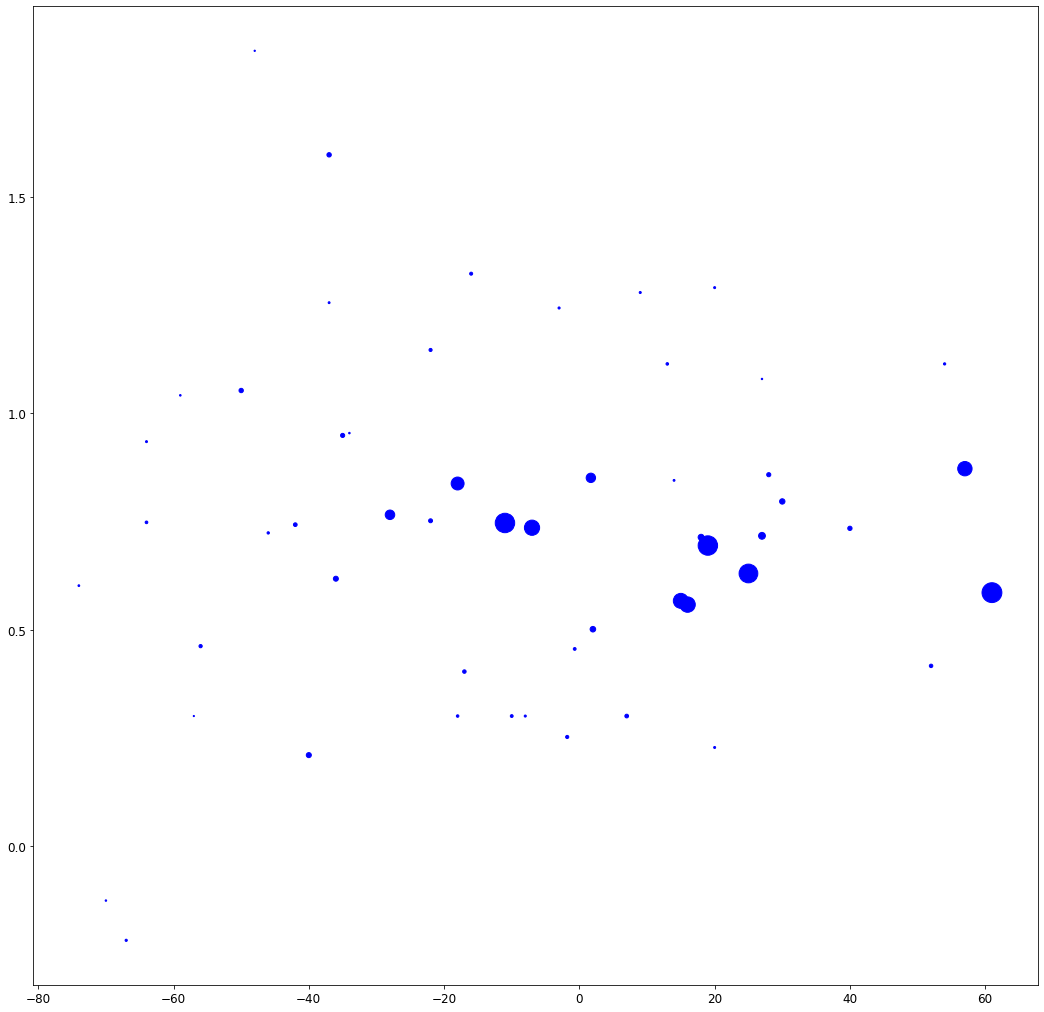

In [134]:
c = ['red' if x>2 else 'blue' for x in y]
plt.scatter(x, y, s=s, c=c)

In [124]:
np.log10(2)

0.3010299956639812

In [49]:
state = df[df['State'] == 'CO']
state

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20
251,0,Statewide Unallocated,CO,8,0,0,0,0,0,0,...,23,23,23,23,23,23,23,23,23,23
252,8001,Adams County,CO,8,0,0,0,0,0,0,...,18226,18690,19178,19705,20346,21175,21789,22149,22905,23339
253,8003,Alamosa County,CO,8,0,0,0,0,0,0,...,393,397,401,413,425,440,449,460,460,465
254,8005,Arapahoe County,CO,8,0,0,0,0,0,0,...,16332,16769,17221,17664,18205,18935,19430,19897,20549,20970
255,8007,Archuleta County,CO,8,0,0,0,0,0,0,...,73,76,76,78,80,90,94,99,101,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,8117,Summit County,CO,8,0,0,0,0,0,0,...,961,978,1023,1030,1057,1094,1116,1128,1149,1173
312,8119,Teller County,CO,8,0,0,0,0,0,0,...,317,327,333,339,357,377,391,401,413,419
313,8121,Washington County,CO,8,0,0,0,0,0,0,...,127,128,128,136,139,146,150,153,156,165
314,8123,Weld County,CO,8,0,0,0,0,0,0,...,7961,8095,8316,8587,8881,9168,9511,9844,10055,10402


In [61]:
state['County Name'][0:30]

251         Statewide Unallocated
252                  Adams County
253                Alamosa County
254               Arapahoe County
255              Archuleta County
256                   Baca County
257                   Bent County
258                Boulder County
259    Broomfield County and City
260                Chaffee County
261               Cheyenne County
262            Clear Creek County
263                Conejos County
264               Costilla County
265                Crowley County
266                 Custer County
267                  Delta County
268                 Denver County
269                Dolores County
270                Douglas County
271                  Eagle County
272                 Elbert County
273                El Paso County
274                Fremont County
275               Garfield County
276                 Gilpin County
277                  Grand County
278               Gunnison County
279               Hinsdale County
280           

In [ ]:
get